In [7]:

from nltk.tokenize import sent_tokenize,word_tokenize
import pandas as pd
import nltk
import re
import numpy as np
import pickle
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('wordnet')


article=pd.read_csv('articles1.csv')

ModuleNotFoundError: No module named 'gensim'

In [2]:
clean_content=[] #contains a list for every row in content column after being preprocessed
tokenized=[]
#tags=[]
lemmatized=[]
stop_words=set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()

for corpus in article['content']:
    corpus=corpus.lower()
    corpus = re.sub(r'[^a-zA-Z0-9\s]', '', corpus)
    #courpus=' '.join(courpus)
    tokenized=word_tokenize(corpus)
    #tags=pos_tag(tokenized) not sure if we need this
    tokenized=[word for word in tokenized if word not in stop_words]
    lemmatized=[lemmatizer.lemmatize(word) for word in tokenized]
    clean_content.append(lemmatized)

In [3]:
cleanCorpus = [' '.join(words) for words in clean_content]

##EDA

In [4]:
# Basic info
print(article.shape)
print(article.columns)

(50000, 10)
Index(['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year',
       'month', 'url', 'content'],
      dtype='object')


In [5]:
article.info()
article.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   50000 non-null  int64  
 1   id           50000 non-null  int64  
 2   title        50000 non-null  object 
 3   publication  50000 non-null  object 
 4   author       43694 non-null  object 
 5   date         50000 non-null  object 
 6   year         50000 non-null  float64
 7   month        50000 non-null  float64
 8   url          0 non-null      float64
 9   content      50000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 3.8+ MB


,Unnamed: 0,id,title,publication,author,date,year,month,url,content
count,50000.000000,50000.000000,50000,50000,43694,50000,50000.000000,50000.000000,0.0,50000
unique,NaN,NaN,49920,5,3603,983,NaN,NaN,NaN,49888
top,NaN,NaN,The 10 most important things in the world righ...,Breitbart,Breitbart News,2016-08-22,NaN,NaN,NaN,advertisement
freq,NaN,NaN,7,23781,1559,221,NaN,NaN,NaN,42
mean,25694.378380,44432.454800,NaN,NaN,NaN,NaN,2016.273700,5.508940,NaN,NaN
std,15350.143677,15773.615179,NaN,NaN,NaN,NaN,0.634694,3.333062,NaN,NaN
min,0.000000,17283.000000,NaN,NaN,NaN,NaN,2011.000000,1.000000,NaN,NaN
25%,12500.750000,31236.750000,NaN,NaN,NaN,NaN,2016.000000,3.000000,NaN,NaN
50%,25004.500000,43757.500000,NaN,NaN,NaN,NaN,2016.000000,5.000000,NaN,NaN
75%,38630.250000,57479.250000,NaN,NaN,NaN,NaN,2017.000000,8.000000,NaN,NaN


In [6]:
# Null values
print(article.isnull().sum())

Unnamed: 0         0
id                 0
title              0
publication        0
author          6306
date               0
year               0
month              0
url            50000
content            0
dtype: int64


In [7]:
#Missing Values Analysis
article['author'] = article['author'].fillna('Unknown')
article.drop(['url'], axis=1, inplace=True)

print(article.isnull().sum())

Unnamed: 0     0
id             0
title          0
publication    0
author         0
date           0
year           0
month          0
content        0
dtype: int64


In [8]:
# Sample content
article.head()

,Unnamed: 0,id,title,publication,author,date,year,month,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ..."


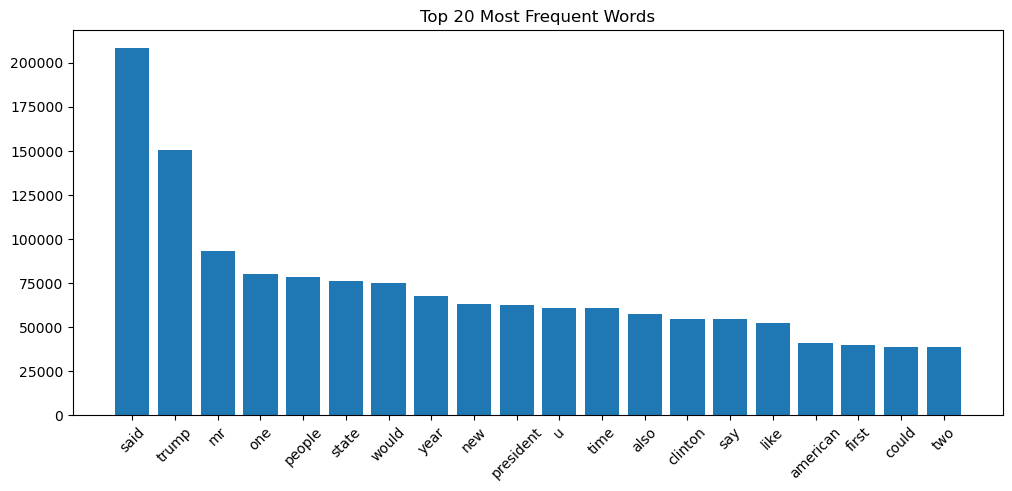

In [9]:
#Most Common Words
from collections import Counter
import matplotlib.pyplot as plt

all_words = [word for doc in clean_content for word in doc]
word_freq = Counter(all_words).most_common(20)

# Bar plot
words, freqs = zip(*word_freq)
plt.figure(figsize=(12, 5))
plt.bar(words, freqs)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.show()


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


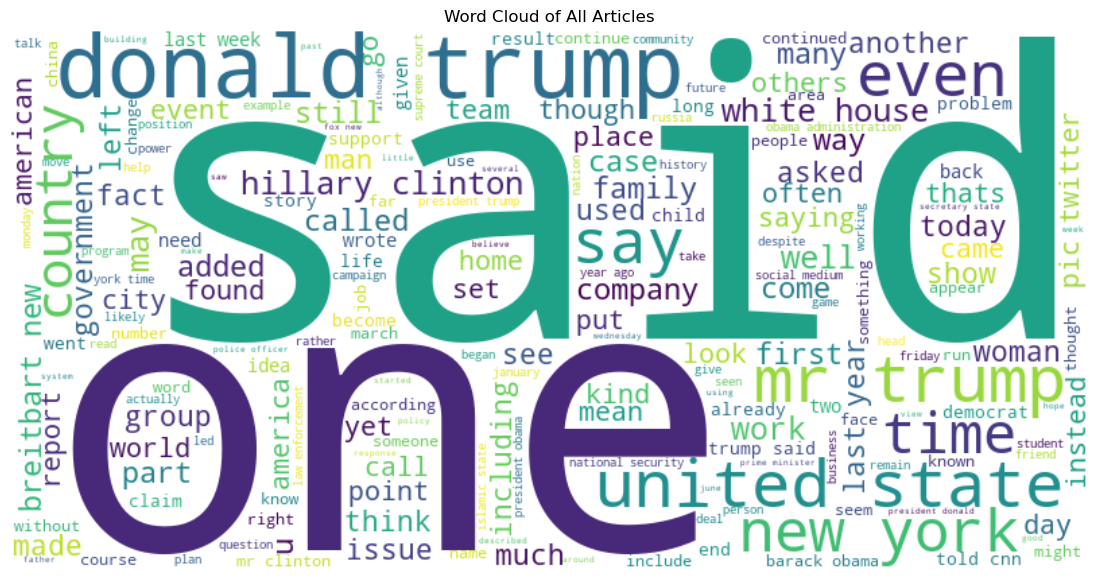

In [11]:
#Word Cloud for Intuition
%pip install wordcloud
from wordcloud import WordCloud

text = ' '.join(cleanCorpus)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Articles")
plt.show()

## Test-Train & Evaluation

In [12]:
X_train, X_test = train_test_split(cleanCorpus, test_size=0.2, random_state=42)

## Feature Extraction

In [13]:
# Bag Of Words (BOW)
cVectorizer = CountVectorizer(max_features=10000, min_df=5, max_df=0.7)
xBow = cVectorizer.fit_transform(X_train)
print("BOW: \n")
print(xBow.shape)
print(cVectorizer.get_feature_names_out())

BOW: 

(40000, 10000)
['000' '10' '100' ... 'zoo' 'zuckerberg' 'zuckerbergs']


In [14]:
# TF-IDF
tfidfVectorizer = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.7)
X_train_tfidf = tfidfVectorizer.fit_transform(X_train)
print("TF-IDF: \n")
print(X_train_tfidf .shape)
print(tfidfVectorizer.get_feature_names_out())

TF-IDF: 

(40000, 10000)
['000' '10' '100' ... 'zoo' 'zuckerberg' 'zuckerbergs']


In [15]:
for i in range(5):
    print(f"Document {i}:")
    print(xBow[i].toarray())
    print(X_train_tfidf [i].toarray())
    print("-" * 80)

Document 0:
[[0 1 0 ... 0 0 0]]
[[0.         0.02395101 0.         ... 0.         0.         0.        ]]
--------------------------------------------------------------------------------
Document 1:
[[0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]]
--------------------------------------------------------------------------------
Document 2:
[[0 1 0 ... 0 0 0]]
[[0.         0.01880503 0.         ... 0.         0.         0.        ]]
--------------------------------------------------------------------------------
Document 3:
[[1 0 0 ... 0 0 0]]
[[0.03763421 0.         0.         ... 0.         0.         0.        ]]
--------------------------------------------------------------------------------
Document 4:
[[0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]]
--------------------------------------------------------------------------------


## Hyperparameter Tuning For Model

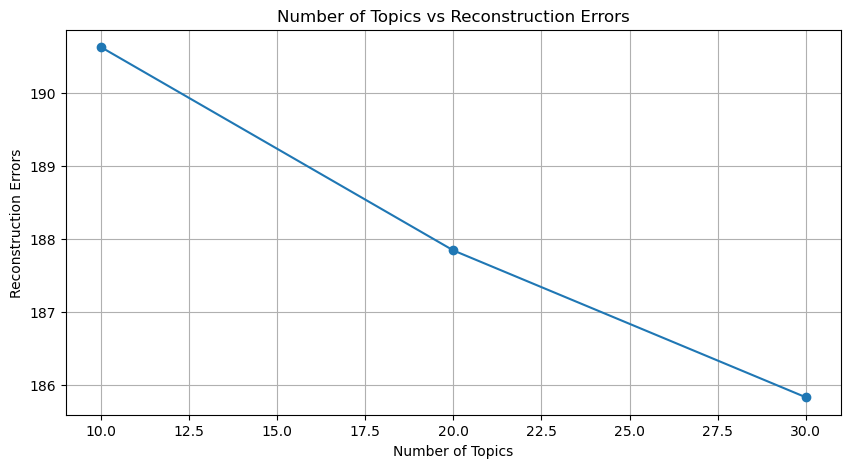

Best number of topics: 30


In [16]:
errors = []
componentRange = range(10, 31, 10)

for component in componentRange:
    nmfTemp = NMF(n_components = component, random_state = 42)
    docTopicTemp = nmfTemp.fit_transform(X_train_tfidf)
    errors.append(nmfTemp.reconstruction_err_)

plt.figure(figsize = (10,5))
plt.plot(componentRange, errors, marker = 'o')
plt.xlabel('Number of Topics')
plt.ylabel('Reconstruction Errors')
plt.title('Number of Topics vs Reconstruction Errors')
plt.grid(True)
plt.show()

bestComponent = componentRange[errors.index(min(errors))]
print(f"Best number of topics: {bestComponent}")

## Model Training and Result Visualization

topic 0: people, think, going, dont
topic 1: trump, donald, campaign, president
topic 2: mr, would, campaign, senator
topic 3: clinton, hillary, email, campaign
topic 4: isi, attack, syria, islamic
topic 5: police, officer, shooting, black
topic 6: obama, president, white, house
topic 7: comey, fbi, investigation, email
topic 8: company, business, apple, billion
topic 9: city, water, new, storm
topic 10: news, breitbart, siriusxm, daily
topic 11: korea, north, korean, missile
topic 12: bill, obamacare, health, care
topic 13: student, school, university, campus
topic 14: migrant, european, eu, britain
topic 15: court, judge, justice, supreme
topic 16: child, family, mother, girl
topic 17: republican, party, democrat, vote
topic 18: israel, israeli, palestinian, jerusalem
topic 19: percent, poll, voter, point
topic 20: gun, amendment, hawkins, awr
topic 21: russian, russia, putin, intelligence
topic 22: cruz, rubio, ted, delegate
topic 23: border, texas, immigration, cartel
topic 24: gam

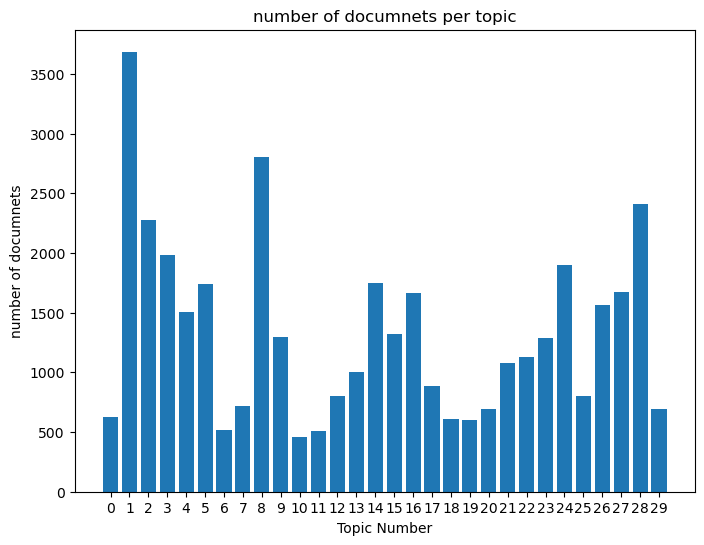

In [17]:
#NMF for TF-IDF
nmf = NMF(n_components=bestComponent, random_state=42)
docTopic = nmf.fit_transform(X_train_tfidf)
topicWord = nmf.components_

featureNames = tfidfVectorizer.get_feature_names_out()
nTopWords =4

for topicIdx, topic in enumerate(topicWord):
    topWordIdx = topic.argsort()[::-1][:nTopWords]
    topWords = [featureNames[i] for i in topWordIdx]
    print(f"topic {topicIdx}: {', '.join(topWords)}")

# each document belongs to the cluster to which it has the highest component of
topicCounts = {}
for doc in docTopic:
    topTopicIdx = doc.argsort()[::-1][0]
    if topTopicIdx not in topicCounts:
        topicCounts[topTopicIdx] = 1
    else:
        topicCounts[topTopicIdx] +=1

# bar chart to visualize topic distribution
topics = list(topicCounts.keys())
docCount = list(topicCounts.values())

plt.figure(figsize=(8,6))
plt.bar(topics, docCount)
plt.xlabel("Topic Number")
plt.ylabel("number of documnets")
plt.title("number of documnets per topic")
plt.xticks(topics)
plt.show()

## Evaluate on Test Data

In [21]:
# 1. Create dictionary and corpus from clean_content (tokenized text)
dictionary = gensim.corpora.Dictionary(clean_content)
corpus = [dictionary.doc2bow(text) for text in clean_content]

# 2. Get feature names from your vectorizer
feature_names = tfidfVectorizer.get_feature_names_out()

# 3. Extract top words per topic
n_top_words = 10
topics = []
for topic_idx, topic in enumerate(topicWord):
    top_word_indices = topic.argsort()[::-1][:n_top_words]
    top_words = [feature_names[i] for i in top_word_indices]
    topics.append(top_words)

# 4. Compute coherence score
coherence_model = gensim.models.CoherenceModel(
    topics=topics,
    texts=clean_content,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f"\nCoherence Score (c_v): {coherence_score:.4f}")


Coherence Score (c_v): 0.7387


In [18]:
from sklearn.metrics import silhouette_score

# --- Transform Test Data ---
X_test_tfidf = tfidfVectorizer.transform(X_test)  # Use same vectorizer
test_doc_topic = nmf.transform(X_test_tfidf)     # Get topic distributions

# Get dominant topic for each document
dominant_topics = np.argmax(test_doc_topic, axis=1)  # Shape: (n_test_docs,)

# Compute silhouette score (lower is better for NMF due to non-Euclidean space)
silhouette = silhouette_score(X_test_tfidf, dominant_topics, metric='cosine')
print(f"Silhouette Score: {silhouette:.3f}")

Silhouette Score: 0.030


## Saving Model

In [19]:
# Save the NMF model
with open('nmf_model.pkl', 'wb') as f:
    pickle.dump(nmf, f)

# Save the TF-IDF vectorizer (crucial for preprocessing new data)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidfVectorizer, f)

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!
